# Tesla Data Challenge
#### Prepared by [Lei Yang](mailto:lei.yng@gmail.com),  5/7/2017

### Executive Summary
- Data are from 99 json files, each representing a part (process object) with ~900 bonds
- The goal is to develop a strategy to predict the `pull test status` (fail/pass) for each bond, with the time series data from 6 parameters (DRIV, DFRM, FREQ, PHAS, US, VOLT)
- Based on different processing time (length of samples of each bond) and data profiles, there appears to be 7 different _types_ of bonds.
- Separate model needs to be built for each type, in this report we will choose one type (with 150 samples) as example, similar approach can be applied to all types of bonds.
- There are 87931 bonds in total, out of which only 15 are failed with the test, 3 inactive, and the rest are all passed. The type we choose for this analysis has the most (9) failed incidents.
- Because the pull test failure is _so_ rare (`~0.02%`), general binary classification model may not be effective as a blind guess of _pass_ would already make the model to have `99.9+%` accuracy. 
- Thus we will use the _novelty/outlier detection_ strategy, to model a distribution for the good bonds and evaluate if a new bond is significantly different.
- We will take 2 steps to investigate the issue (refer to results below):
 - From exploratory analysis, we visually check if there are significant and consistent difference between the univariate trace profile, by overlaying data of pass/fail bonds of different types.
 - Extract features from the process, and build multivariate novelty detection model.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import normalize

# short-hand variable to extract data
TS, PT = 'TRACE_SAMPLES', 'PULL_TEST_STATUS'

## 1. Exploratory Data Analysis

#### Count pass / non_pass bond

In [2]:
n_bond, n_fail = 0, 0
for i in range(100):
    try:
        f1 = pd.read_json('archive/interconnect_json/file_%d.json' %(i+1))
        status = [0 if b[PT]=='Pass' else 1 for b in f1.BONDS]
        n_bond += len(status)
        n_fail += sum(status)
    except:
        print('failure loading file #%d' %(i+1))

print('total bonds: %d, failure: %d' %(n_bond, n_fail))

failure loading file #58
total bonds: 87931, failure: 18


#### Check sample size of each bond

In [4]:
bond_len = []
for i in range(100):
    if i == 57: continue
    f = pd.read_json('archive/interconnect_json/file_%d.json' %(i+1))
    bond_len += [len(b[TS]) for b in f.BONDS]

pd.Series(bond_len).value_counts()

105    28704
150    19859
350    19232
189    10368
95      4884
183     2442
208     2442
dtype: int64

#### Define plotting functions

In [5]:
def plot_bond(bond):
    '''
    chart 6 parameters of a bond
    '''
    print('Pull test status: %s' %bond['PULL_TEST_STATUS'])
    params = ['DFRM','DRIV','FREQ','PHAS','US','VOLT']
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    ind = [s['SAMPLE'] for s in bond['TRACE_SAMPLES']]    
    for ax,param in zip(axes.flatten(), params):
        ax.plot(ind, [s[param] for s in bond['TRACE_SAMPLES']], '.')
        ax.set_title(param)
    fig.tight_layout()    
    plt.show()
    
def plot_bonds(bonds):
    '''
    overlay 6 parameters of a group of bonds
    '''
    print('Pull test status: %s' %np.unique([b['PULL_TEST_STATUS'] for b in bonds]))
    params = ['DFRM','DRIV','FREQ','PHAS','US','VOLT']
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    for ax,param in zip(axes.flatten(), params):
        ax.set_title(param)
        for b in bonds:
            ax.plot([s[param] for s in b['TRACE_SAMPLES']], '.')
    fig.tight_layout()
    plt.show()
    
def plot_compare(bonds):
    '''
    overlay 6 parameters of pass (green) and fail (red) bonds
    '''
    params = ['DFRM','DRIV','FREQ','PHAS','US','VOLT']
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    for ax,param in zip(axes.flatten(), params):
        ax.set_title(param)
        for b in bonds:  
            xy = np.array([(s['SAMPLE'], s[param]) for s in b['TRACE_SAMPLES']])
            ax.plot(xy[:,0], xy[:,1], 'b.' if b['PULL_TEST_STATUS']=='Pass' else 'r.')
    fig.tight_layout()
    plt.show()
    

def plot_all(bond_type, files = None):
    '''
    overlay 4 parameters of pass (green) and fail (red) bonds, for a given type from a group of parts/files
    '''
    params = ['DFRM','FREQ','US','VOLT']
    fig, axes = plt.subplots(nrows=int(np.ceil(len(params)/2.0)), ncols=2, figsize=(15,10))
    no_pass = []
    for i in range(100) if not files else files:
        if i == 57: continue
        bonds = pd.read_json('archive/interconnect_json/file_%d.json' %(i+1)).BONDS
        
        for ax,param in zip(axes.flatten(), params):
            ax.set_title(param)
            for b in bonds:  
                if len(b[TS]) == bond_type:
                    if b[PT] == 'Pass':
                        xy = np.array([(s['SAMPLE'], s[param]) for s in b[TS]])
                        ax.plot(xy[:,0], xy[:,1], 'b.')
                    else:
                        no_pass.append(b)

    # plot failed bonds last
    for ax,param in zip(axes.flatten(), params):
        for b in no_pass:
            xy = np.array([(s['SAMPLE'], s[param]) for s in b[TS]])
            ax.plot(xy[:,0], xy[:,1], 'r.')
        
    fig.tight_layout()
    plt.show()

#### Get data of non-pass bonds,  show type and file ID of each fail bond

In [6]:
failed_bond = []
for i in range(100):
    if i==57: continue
    f = pd.read_json('archive/interconnect_json/file_%d.json' %(i+1))
    for b in f.BONDS: 
        if b[PT] != 'Pass':
            failed_bond.append((b, len(b[TS]), f['FILE_ID'][0]))

# show failed bonds
[(l,f,b[PT]) for b,l,f in failed_bond if b[PT]=='Fail']

[(189, 3, 'Fail'),
 (150, 28, 'Fail'),
 (150, 29, 'Fail'),
 (350, 36, 'Fail'),
 (350, 46, 'Fail'),
 (150, 59, 'Fail'),
 (150, 61, 'Fail'),
 (150, 65, 'Fail'),
 (350, 73, 'Fail'),
 (350, 95, 'Fail'),
 (350, 95, 'Fail'),
 (150, 96, 'Fail'),
 (150, 99, 'Fail'),
 (150, 99, 'Fail'),
 (150, 99, 'Fail')]

### Univariate trace comparison
- Verified the _drive (DRIV)_ is identical for each type, it looks like an input parameter of the test
- Bond _oscillation phase (PHAS)_ doesn't show too much pattern besides a while noise around zero, we will neglect in this analysis
- Bonds with 150 and 189 samples are plotted for all files, bond with 350 samples are only plotted from the parts (files) that have the failing bonds.
- No significant difference are found between fail and pass for bonds with 150 and 350 samples.
- The one failed bond with 189 samples has significant difference in frequency, current and voltage. However with only one failing example, it can hard be conclusive.

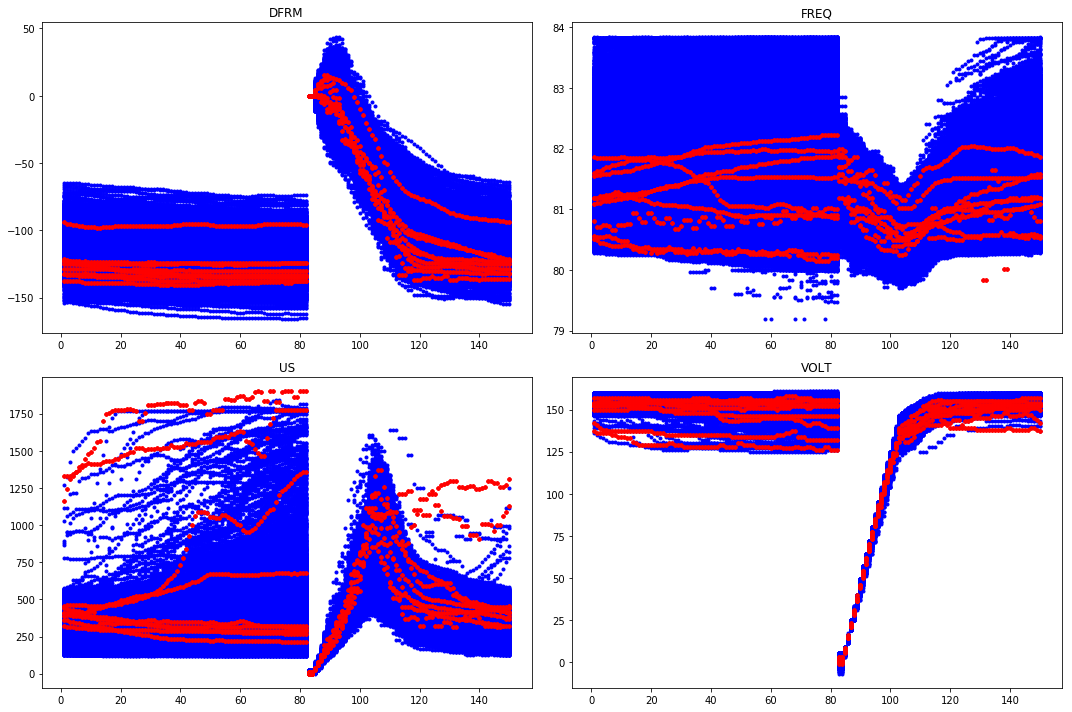

In [149]:
plot_all(150)

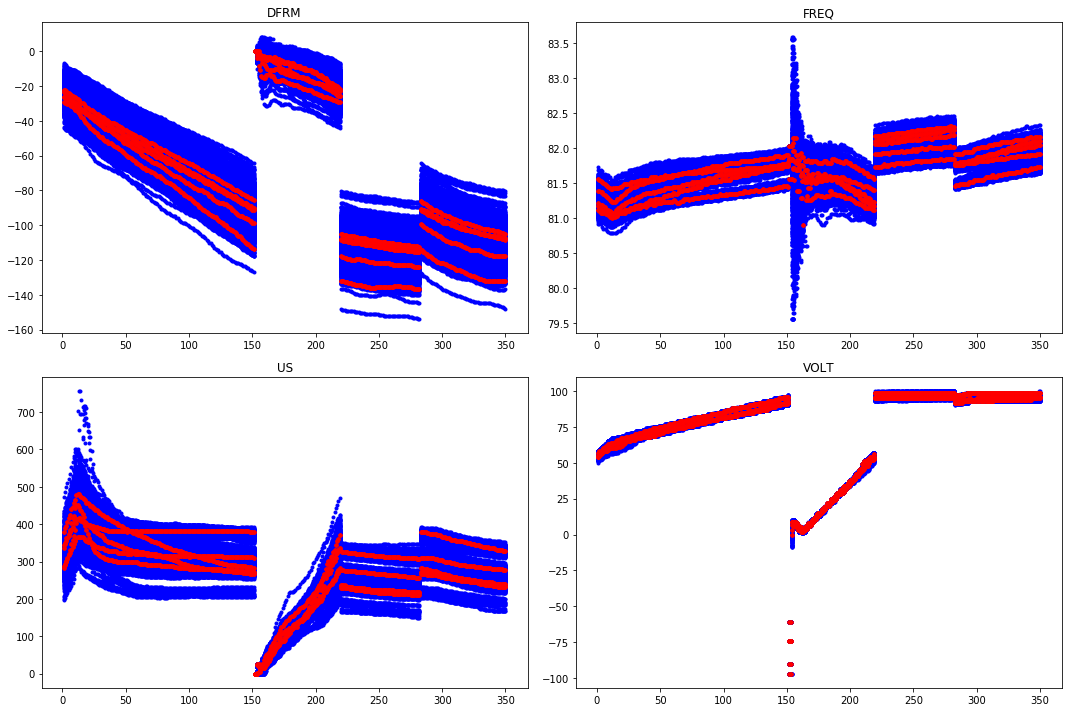

In [153]:
plot_all(350, [35,45,72,94])

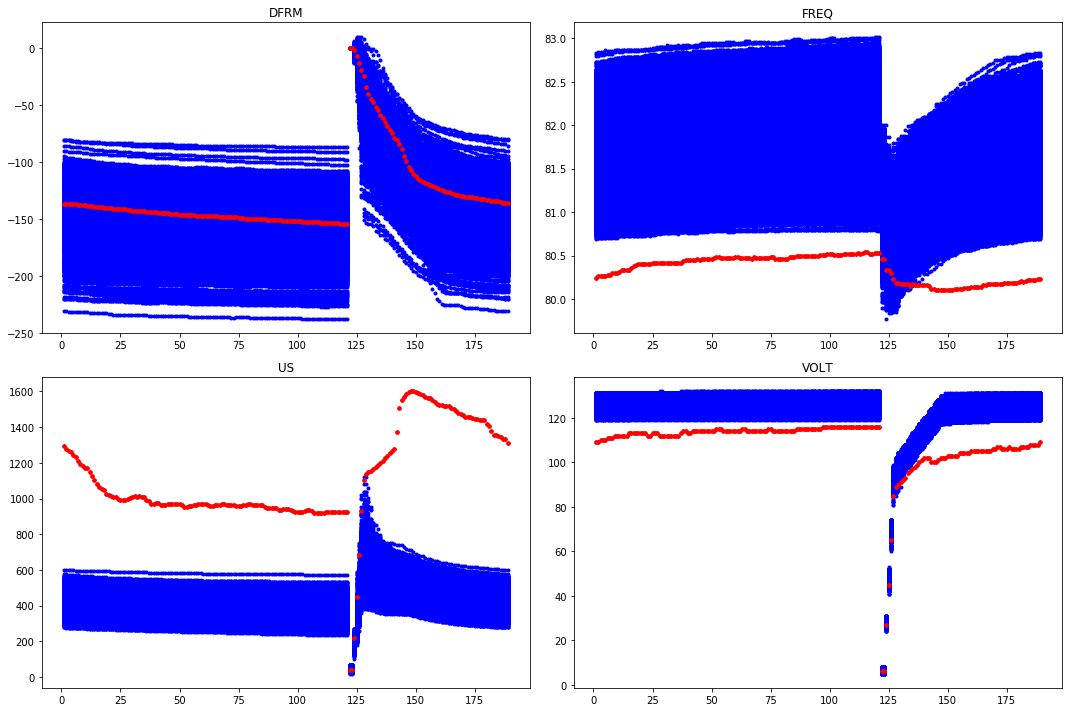

In [156]:
plot_all(189)

## 2. Multivariate modeling 
- For the bonds with 150 samples, there are 2 sections of the process. A static part at the beginning before the _drive_ suddenly drops, and a dynamic part when it climbs back to the original level
- We will only include the features (mean, sdDev) for the static part from the 4 parameters to build novelty detection model

#### Extract static feature
- In the boxplot, the failed bonds are depicted by red dots

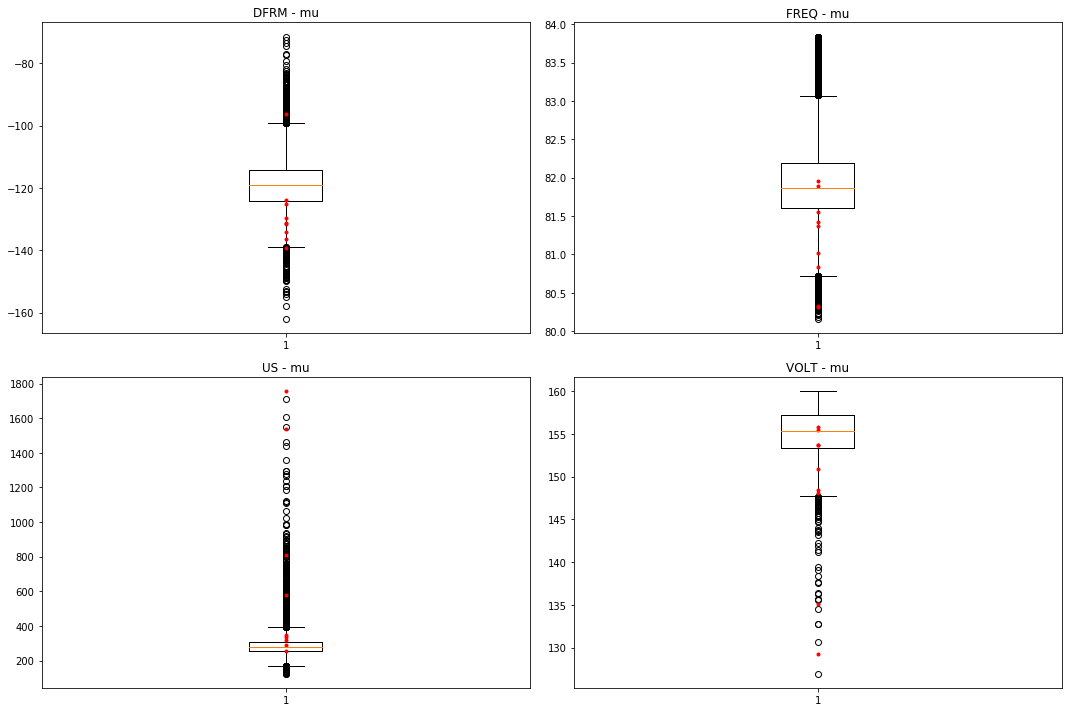

In [3]:
pass_stat, fail_stat = [], []
for i in range(100):
    if i==57: continue
    f = pd.read_json('archive/interconnect_json/file_%d.json' %(i+1))
    for b in f.BONDS: 
        if len(b[TS]) == 150:
            fea = np.array([(s['DRIV'],s['DFRM'],s['FREQ'],s['US'],s['VOLT']) for s in b[TS]])
            ind = (abs(fea[1:,0]-fea[:-1,0])>100).tolist().index(True)+1
            static = fea[:ind,:]
            if b[PT] == 'Pass':
                pass_stat.append((static.mean(axis=0), static.std(axis=0)))
            else:
                fail_stat.append((static.mean(axis=0), static.std(axis=0)))
            

pass_mu = np.vstack([a[0] for a in pass_stat])
pass_sd = np.vstack([a[1] for a in pass_stat])
fail_mu = np.vstack([a[0] for a in fail_stat])
fail_sd = np.vstack([a[1] for a in fail_stat])

params = ['DRIV', 'DFRM', 'FREQ', 'US', 'VOLT']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for ax,i in zip(axes.flatten(), np.arange(1,5)):
    ax.set_title(params[i] + ' - mu')
    ax.boxplot(pass_mu[:,i])
    ax.plot([1]*len(fail_mu), fail_mu[:,i], 'r.')
fig.tight_layout()
plt.show()    


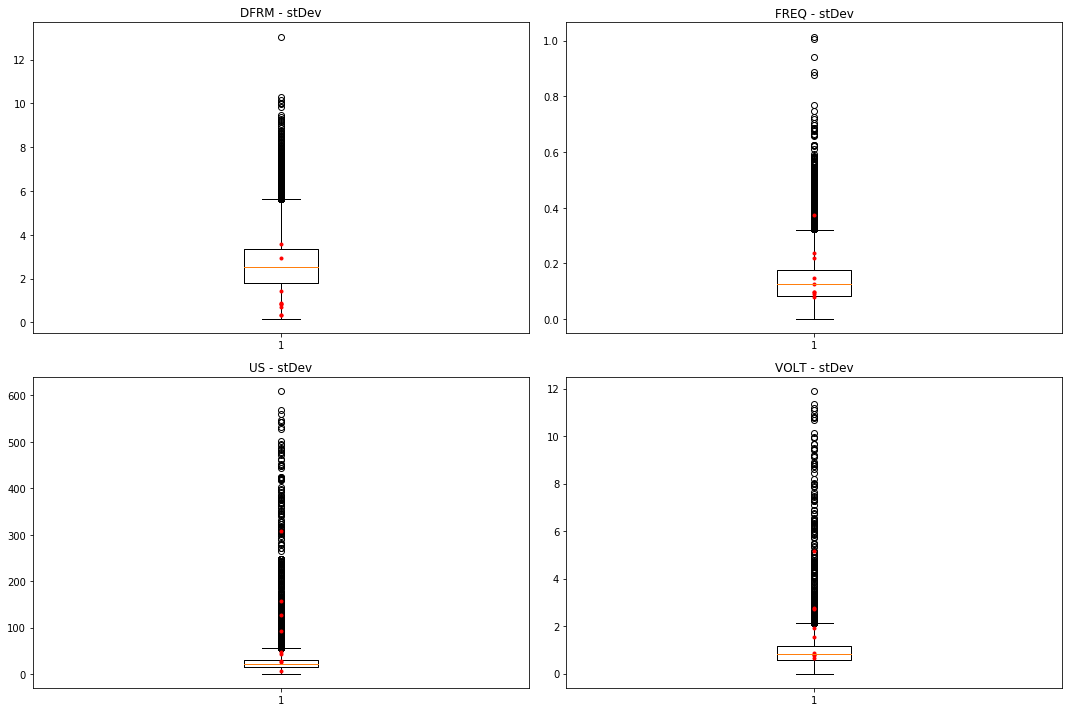

In [4]:
params = ['DRIV', 'DFRM', 'FREQ', 'US', 'VOLT']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for ax,i in zip(axes.flatten(), np.arange(1,5)):
    ax.set_title(params[i] + ' - stDev')
    ax.boxplot(pass_sd[:,i])
    ax.plot([1]*len(fail_sd), fail_sd[:,i], 'r.')
fig.tight_layout()
plt.show()

### Build one-class SVM model
- With a polynomial kernel, 4 out of 9 failed bonds can be detected. 
- The training accuracy looks ok but within our context when the novelty is rare, it would still give 592 false alarms, which puts the practical value in question.

In [5]:
n_pass_fea = normalize(np.hstack([pass_mu[:,1:], pass_sd[:,1:]]))
n_fail_fea = normalize(np.hstack([fail_mu[:,1:], fail_sd[:,1:]]))

In [67]:
clf = svm.OneClassSVM(nu=0.03, kernel='poly', gamma=0.1, degree=3)
clf.fit(n_pass_fea)
print('Training accuracy: %.2f%%' %(100*sum(clf.predict(n_pass_fea)==1)/n_pass_fea.shape[0]))

Training accuracy: 97.02%


In [68]:
clf.predict(n_fail_fea)

array([ 1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.])

## TODO:
- Extract more features, i.e. dynamic features; and include more parameters if possible
- Further tune the hyper-parameters of SVM, i.e. kernel, margin, noise etc.
- Explore other models, i.e. mixture model, ensemble of tree-based classifiers etc.

### MongoDB for processing Json data
- Basic data processing for EDA and feature extraction can be achieved by running MongoDB query, instead of organically doing it with Python snippets.
- Below is an example to extract voltage parameter from bonds with 150 samples

In [13]:
!mongoimport -d tesla -c bond --file /Users/leiyang/Downloads/archive/interconnect_json/file_10.json

2017-05-06T21:59:58.191-0400	connected to: localhost
2017-05-06T21:59:59.469-0400	imported 1 document


In [1]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
bonds = client.tesla.bond

In [9]:
rtn = bonds.find_one({'BONDS.TRACE_SAMPLES':{'$size':150}}, 
                     {'BONDS.TRACE_SAMPLES.VOLT':1, 'BONDS.TRACE_SAMPLES.SAMPLE':1, '_id':0})

## Backup charts

bond processing time: 105
Pull test status: ['Pass']


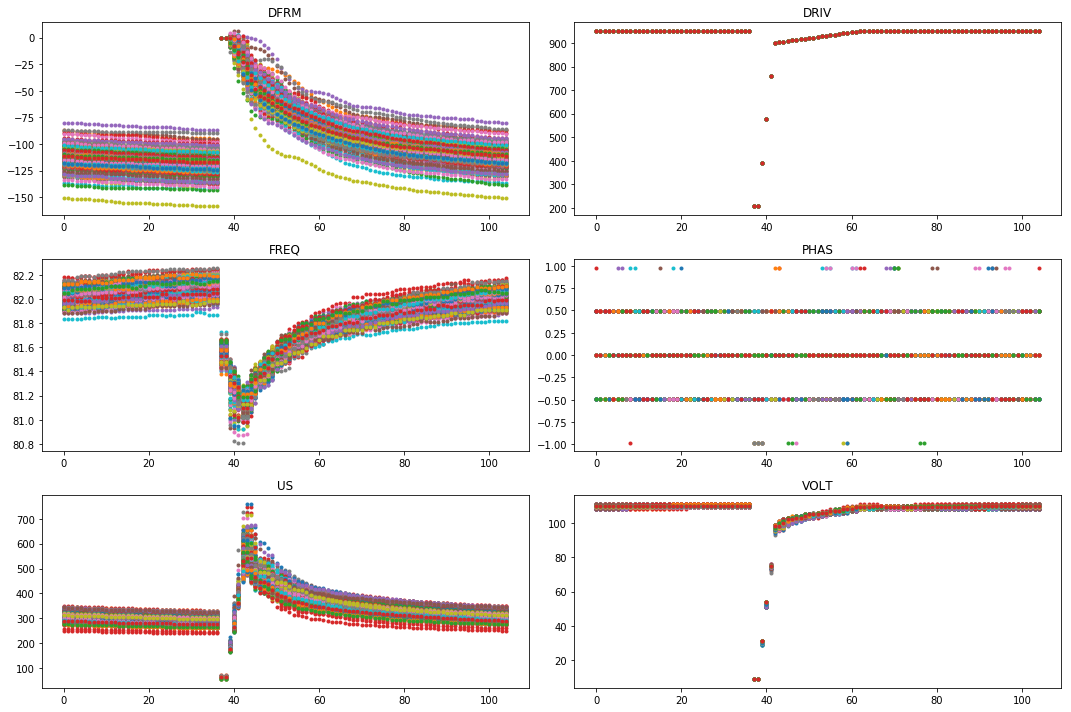

bond processing time: 150
Pull test status: ['Pass']


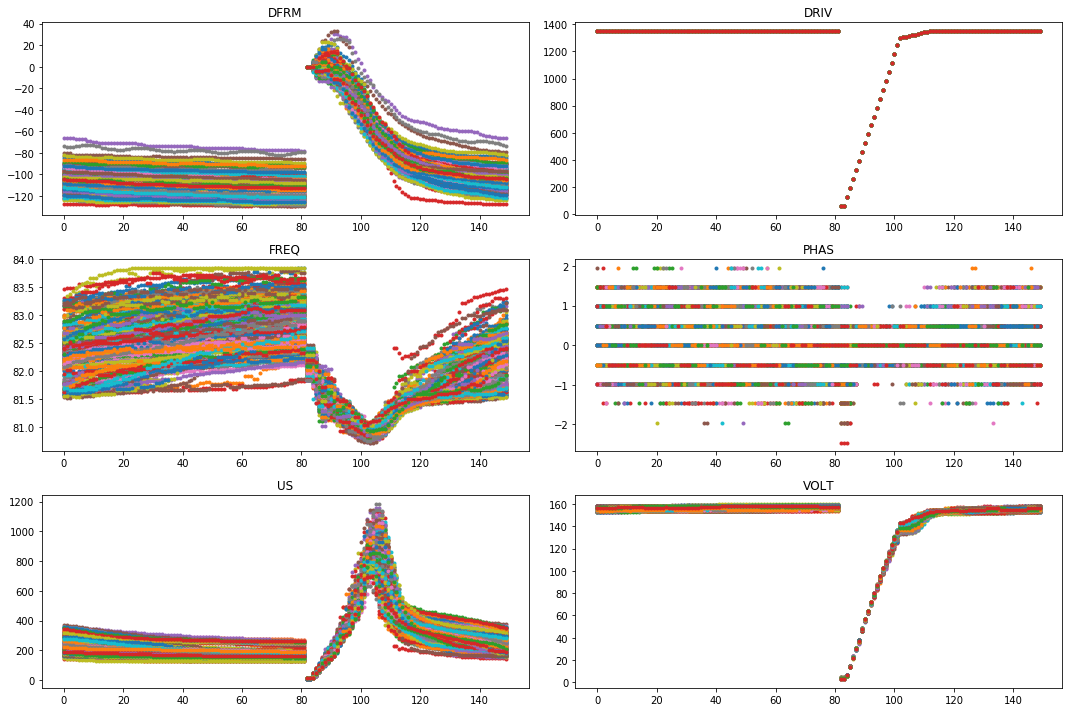

bond processing time: 350
Pull test status: ['Fail' 'Pass']


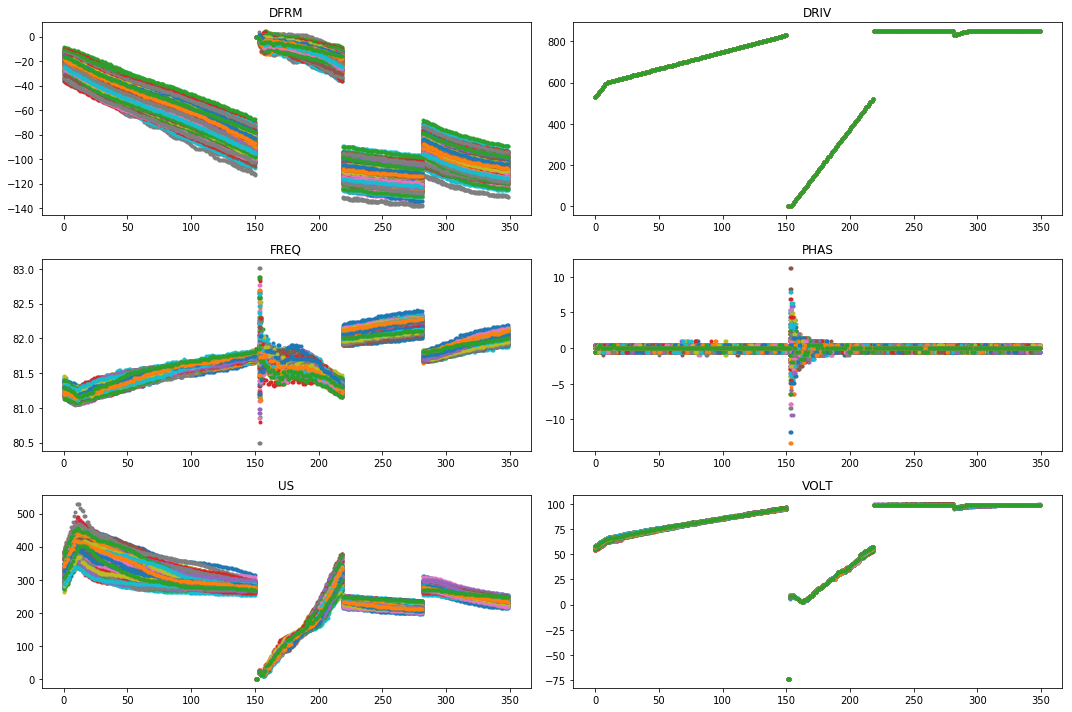

In [186]:
for bt in np.unique([len(b[TS]) for b in file.BONDS]):
    print('bond processing time: %d' %bt)
    plot_bonds([b for b in file.BONDS if len(b[TS])==bt])

Pull test status: ['Fail']


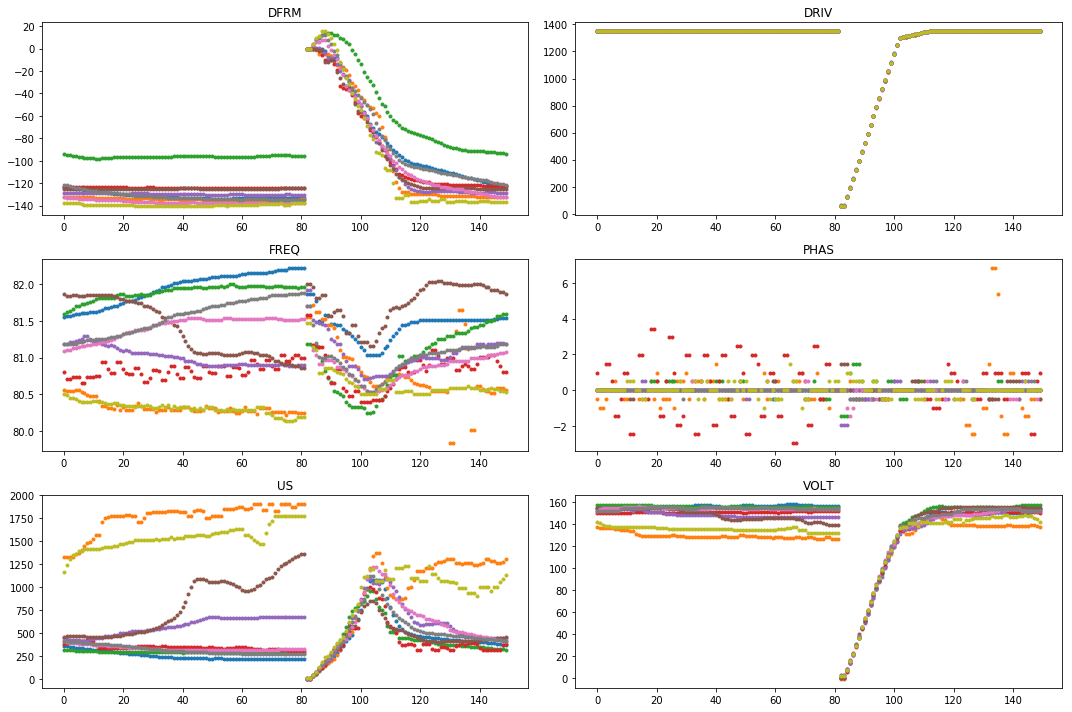

In [115]:
plot_bonds([b for b in failed_bond if len(b[TS])==150 and b[PT]=='Fail'])

Pull test status: ['Fail']


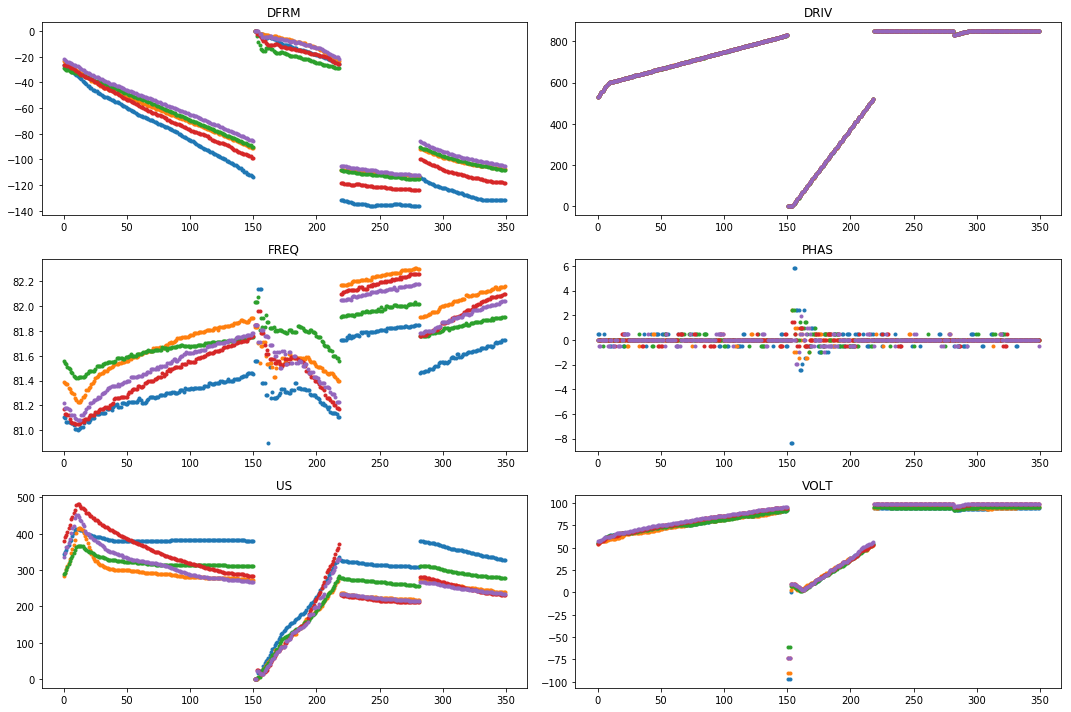

In [106]:
plot_bonds([b for b in failed_bond if len(b[TS])==350 and b[PT]=='Fail'])

Pull test status: ['Pass']


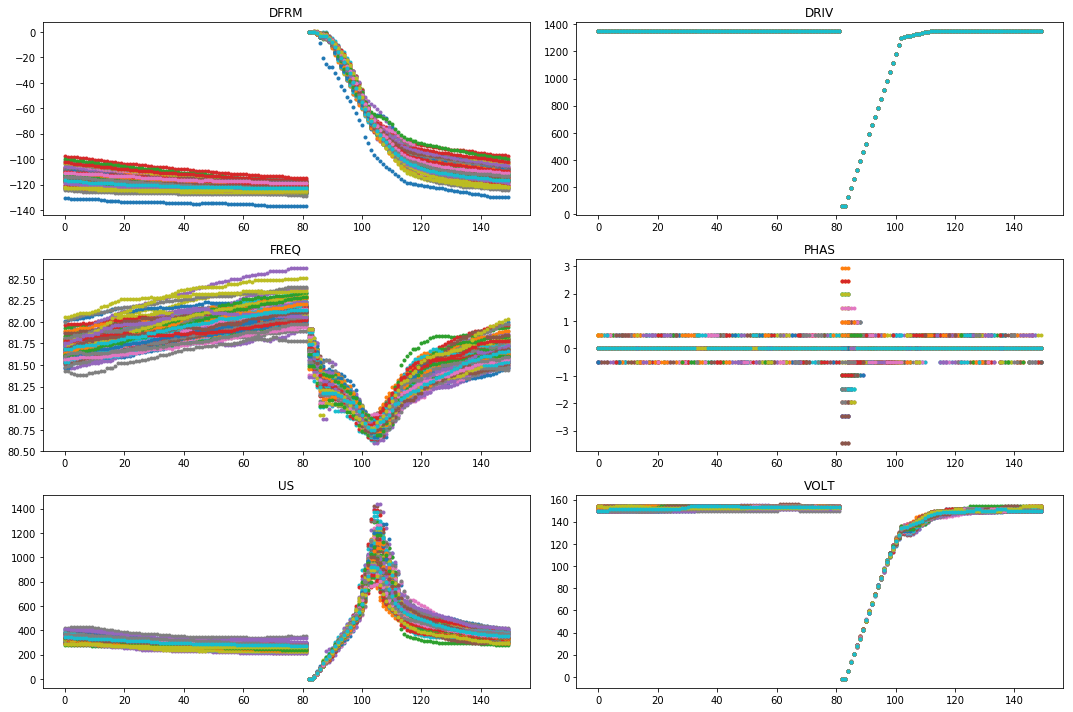

In [117]:
plot_bonds([b for b in f1.BONDS if len(b[TS])==150][:100])

Pull test status: ['Pass']


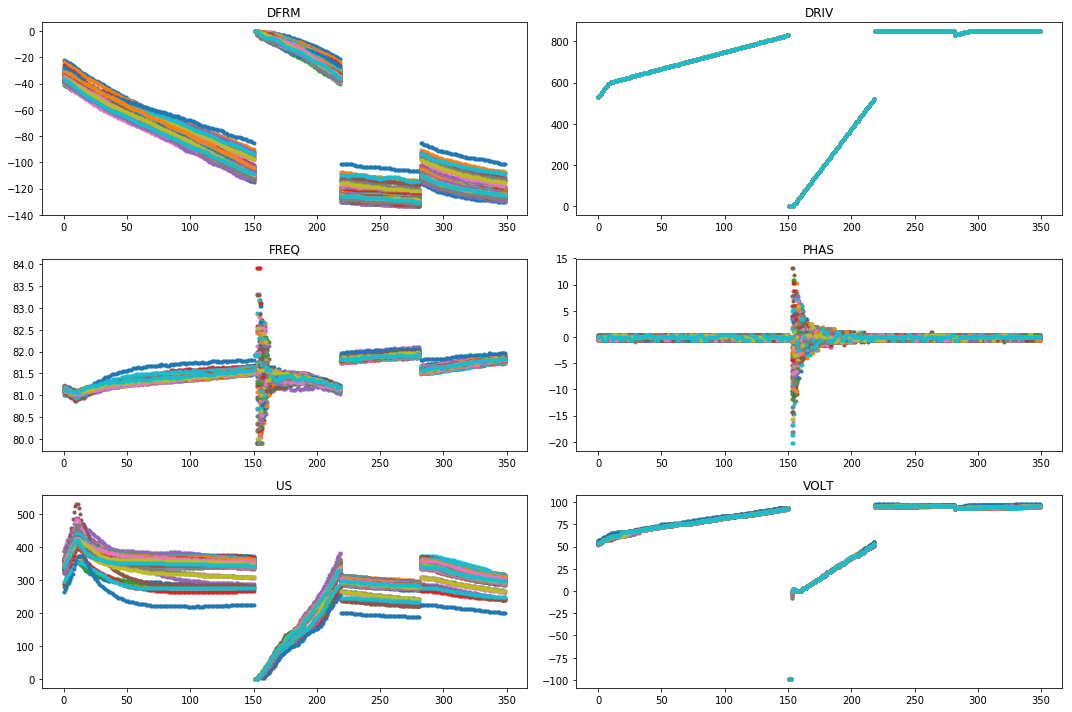

In [118]:
plot_bonds([b for b in f1.BONDS if len(b[TS])==350][:100])